In [1]:
import sys
sys.path.append("..")
from mpmath import hyp2f1, gamma
import mpmath as mp
from qtn.util import (boltzmann, emass, echarge, permittivity, cspeed)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def zk(z, k):
    """
    modified dispersion function for Kappa distribution.
    (Mace and Hellberg, 1995)
    
    """
    i = mp.mpc(0, 1)
    coeff = i * (k + 0.5) * (k-0.5) / (mp.sqrt(k**3) * (k+1))
    return coeff * hyp2f1(1, 2*k+2, k+2, (1-z/(i * mp.sqrt(k)))/2)

In [3]:
def f1(x):
    """
    An angular integral that appears in electron noise calculation.
    
    """
    term1 = x * (mp.si(x) - 0.5 * mp.si(2*x))
    term2 = -2 * mp.sin(0.5 * x)**4
    return (term1 + term2)/x**2

In [4]:
def e_l(z, wrel, k):
    """
    Longitudinal susceptibility tensor.
    wrel:= w/wp
    k:= kappa
    z:= zeta = w/kv0
    v0:=characteristic speed. 
    See Chateau & Meyer-Vernet (1991)
    """
    
    return 1 + 2*(z/wrel)**2 * (1 - 0.5/k + z * zk(z, k))

In [5]:
def kappa_integrand(z, wrel, lrel, k):
    """
    z:= zeta = w/kv0
    lrel:= l/ld
    k:= kappa
    """
    
    f_arg = wrel * lrel * mp.sqrt(k/(2*(k-1)))/z
    num = z * f1(f_arg)
    denom = mp.fabs(e_l(z, wrel, k))**2 * (1+z**2/k)**k
    return num/denom

In [6]:
def int_interval(wrel, k):
    """
    find out the almost-singular point and
    divide the integration integrals.
    
    """
    if wrel < 1:
        return [0, mp.inf]
    else:
        guesses = [4, 6, 8, 10, 12, 14]
    int_range = [0, mp.inf]
    for guess in guesses:
        try:
            root = mp.findroot(lambda z: e_l(z, wrel, k), guess)
        except ValueError:
            continue
        unique = True
        for z in int_range:
            if mp.fabs(z - mp.fabs(root)) < 1e-4:
                unique = False
        if unique:
            int_range += [mp.fabs(root)]
    int_range = np.sort(int_range)
    return int_range

In [7]:
mp.mp.dps = 20
wrel = 1.1
lrel = 8
k= 4
root = int_interval(wrel, k)
print(root)
print(e_l(root[1], wrel, k))

[0 mpf('4.2042154496394818269766') mpf('+inf')]
(0.019430498652077038095 + 0.042061145169205265451j)


In [8]:
def kappa(wrel, lrel, k, T):
    """
    electron noise for electrons with a kappa distribution.
    
    """
    coeff = 16 * emass/ permittivity / wrel**2 * gamma(k+1)/gamma(k-1/2)
    coeff *= (mp.pi * k)**(-3/2) * mp.sqrt(boltzmann * T/emass * (2*k-3)/k)
    int_range = int_interval(wrel, k)
    integral = mp.quad(lambda z: kappa_integrand(z, wrel, lrel, k), int_range)
    return coeff * integral

In [9]:
wrelplot = np.logspace(-1, 1, 20)
extra = np.array([0.95, 0.96, 0.97, 0.98, 0.99, 1.005, 1.01, 1.02, 1.03, 1.04, 1.05, 1.6, 1.07, 1.09, 1.11])
wrelplot = np.concatenate((wrelplot, extra))
wrelplot = np.sort(wrelplot)
print(wrelplot)
lrelplot = np.array([0.125, 0.25, 0.5, 1, 2, 4, 8])

[ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183
  0.42813324  0.54555948  0.6951928   0.88586679  0.95        0.96
  0.97        0.98        0.99        1.005       1.01        1.02
  1.03        1.04        1.05        1.07        1.09        1.11
  1.12883789  1.43844989  1.6         1.83298071  2.33572147  2.97635144
  3.79269019  4.83293024  6.15848211  7.8475997  10.        ]


In [10]:
mp.mp.dps = 15
vw2 = np.array([np.array([kappa(wrel, lrel, 4, 1) for wrel in wrelplot]) for lrel in lrelplot])

In [11]:
vw2[0,:]

array([mpf('1.224703087468589e-18'), mpf('1.2248315880162908e-18'),
       mpf('1.2250409026747175e-18'), mpf('1.2253829577341256e-18'),
       mpf('1.2259451651563395e-18'), mpf('1.2268793934276061e-18'),
       mpf('1.228464560855318e-18'), mpf('1.2312666689024779e-18'),
       mpf('1.236672271800815e-18'), mpf('1.2499284851749913e-18'),
       mpf('1.2589404266335428e-18'), mpf('1.2609277991637698e-18'),
       mpf('1.2632062035028794e-18'), mpf('1.2659002097736513e-18'),
       mpf('1.2692683192928847e-18'), mpf('1.6733679319460634e-18'),
       mpf('1.5570119425460687e-18'), mpf('1.4752869240214156e-18'),
       mpf('1.439274910868444e-18'), mpf('1.4177612170124349e-18'),
       mpf('1.4029320545663106e-18'), mpf('1.382914685828403e-18'),
       mpf('1.3691907108444176e-18'), mpf('1.3585631539499649e-18'),
       mpf('1.3501583753132568e-18'), mpf('1.2584119566892264e-18'),
       mpf('1.2175871159273617e-18'), mpf('1.1625854032555307e-18'),
       mpf('1.0584104963575869e-18'), m

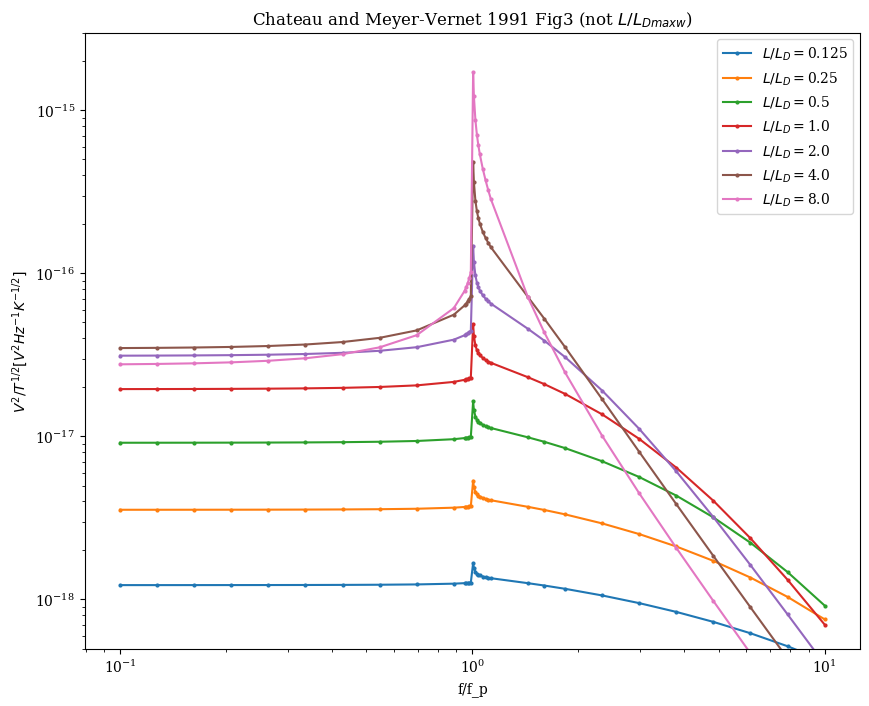

In [12]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
fig = plt.figure(figsize = [10, 8])
for i in range(7):
    plt.plot(wrelplot, vw2[i,:], 'o-', markersize = 2,
             label=r'$L/L_D=$'+str(lrelplot[i]))
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-19, 3e-15)
plt.xlabel(r'f/f_p')
plt.ylabel(r'$V^2/T^{1/2}[V^2Hz^{-1}K^{-1/2}]$')
plt.legend(loc='best')
plt.title('Chateau and Meyer-Vernet 1991 Fig3 (not $L/L_{Dmaxw}$)')
plt.show()

In [13]:
fig.savefig('example.png', dpi = 300)

###### impedance